In [49]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
using IterTools
using DelimitedFiles


# Phase Space interaction-autoinfection

In [2]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

fr = 0.0
dil = 0.0
d = 3 # degree (fixed for now) 
T = 8 # discrete time

grid = 20
γvalues = LinRange(0.01,0.25,grid) # planted autoinfection probability
λvalues = γvalues # planted infection rate
folderstring = "./T=$(T)_d=$(d)_min=$(γvalues[1])_max=$(γvalues[end])_fr=$(fr)_dil=$(dil)/"

"./T=8_d=3_min=0.01_max=0.25_fr=0.0_dil=0.0/"

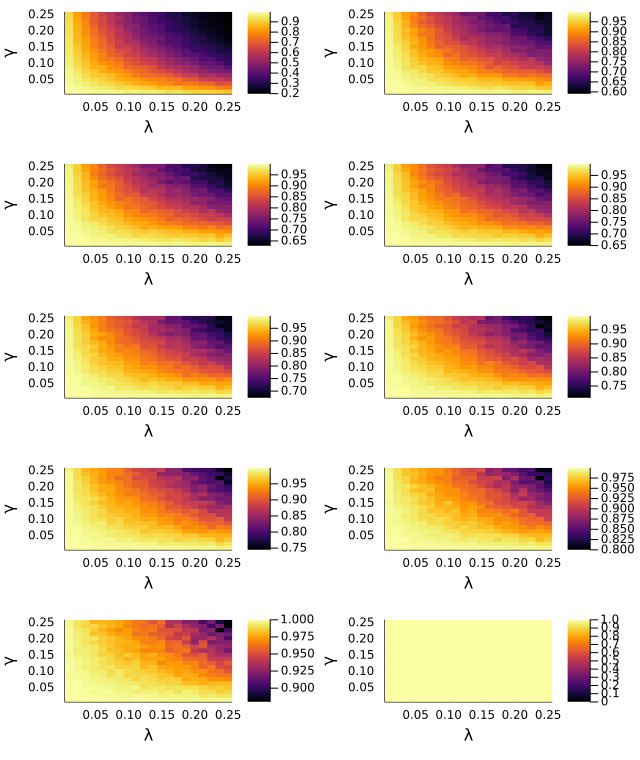

In [3]:
diag = readdlm("$(folderstring)diag.txt")
AUC = zeros(grid,grid,T+2)
for t = 2 : T + 2 
    AUC[:,:,t] .= readdlm("$(folderstring)AUC$(t - 1).txt") 
end

AUC[isnan.(AUC)] .= 1 ;
hdiag = heatmap(γvalues,λvalues,diag)
hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

for t = 2 : T + 2 
    hAUC[t-1] = heatmap(γvalues,λvalues,AUC[:,:,t]) 
end

plot(hdiag, hAUC..., size=(640,760),layout = (5, 2),xlabel="λ",ylabel="γ")

#savefig("inference.pdf")

# Phase Space FalseRate - Dilution

In [51]:
grid = 7
T = 8
graphtypes= ["rr","er"]
graph = graphtypes[2]
samp = 1;

In [52]:
frRange = LinRange(0.0,0.5,grid) # planted autoinfection probability
dilRange = LinRange(0.0,1.0,grid) # planted infection rate

diag = readdlm("./fr_dil_$(graph)_$(samp)/diag.txt")
AUC = zeros(grid,grid,T+2)
for t = 2 : T + 2 
    AUC[:,:,t] .= readdlm("./fr_dil_$(graph)_$(samp)/AUC$(t - 1).txt") 
end

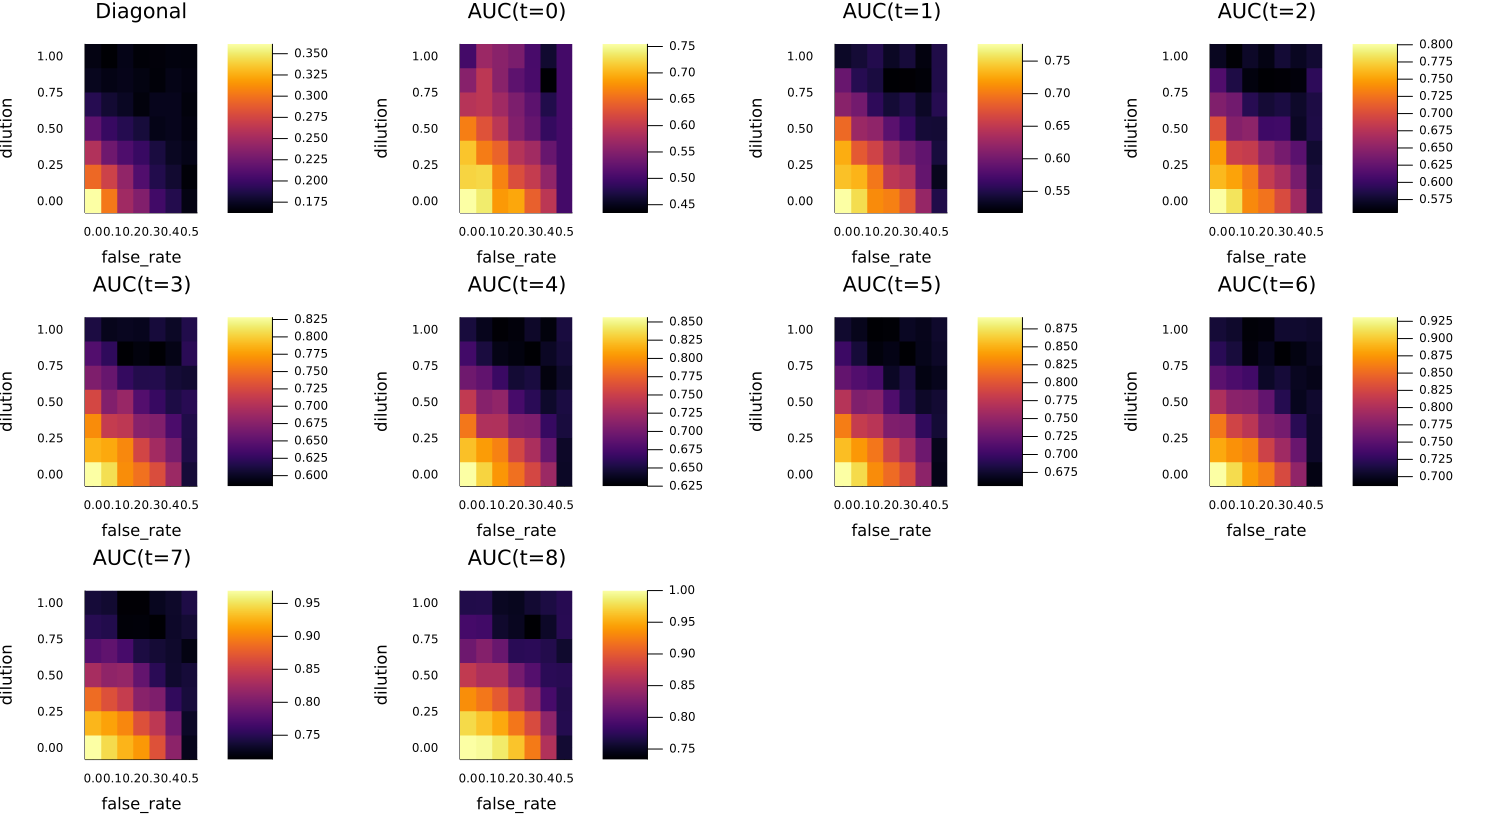

In [53]:
AUC[isnan.(AUC)] .= 1 ;
hdiag = heatmap(frRange,dilRange,diag,title="Diagonal")
hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

for t = 2 : T + 2 
    hAUC[t-1] = heatmap(frRange,dilRange,AUC[:,:,t],title="AUC(t=$(t-2))") 
end

plot(hdiag, hAUC..., size=(1500,820),layout = 10,ylabel="dilution",xlabel="false_rate",margin=5Plots.mm)

In [25]:
savefig("fr_dil2.pdf")

# Phase Space Interaction - Dilution

In [41]:
grid = 7
T = 8
graphtypes= ["rr","er"]
graph = graphtypes[1]
samp = 1;

In [42]:
λRange = LinRange(0.01,0.5,grid)
dilRange = LinRange(0.0,1.0,grid)

diag = readdlm("./dil_lam_$(graph)_$(samp)/diag.txt")
AUC = zeros(grid,grid,T+2)
for t = 2 : T + 2 
    AUC[:,:,t] .= readdlm("./dil_lam_$(graph)_$(samp)/AUC$(t - 1).txt") 
end

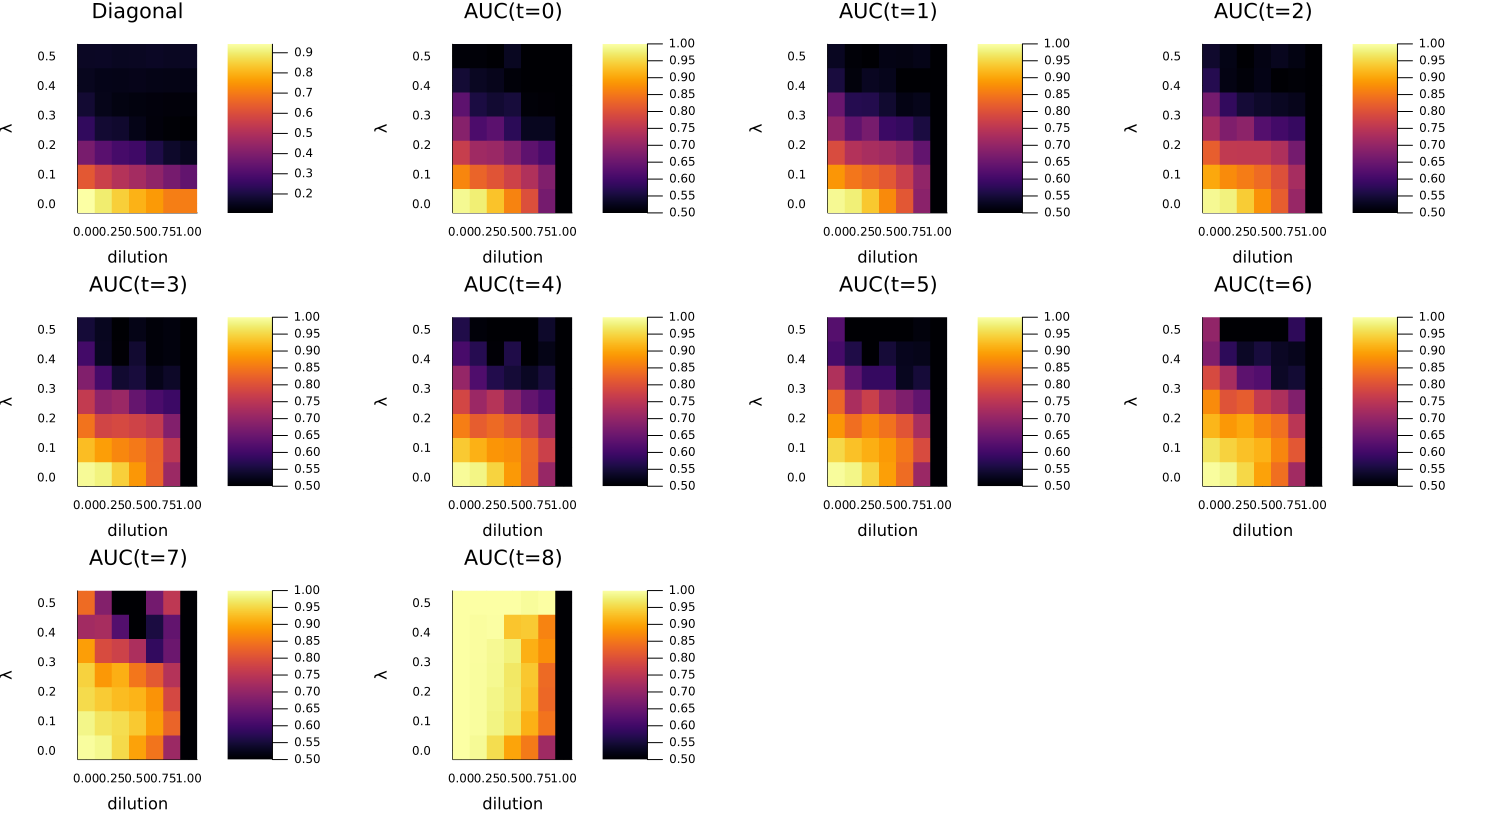

In [48]:
AUC[isnan.(AUC)] .= 1 ;
hdiag = heatmap(dilRange,λRange,diag,title="Diagonal")
hAUC = Array{Plots.Plot{Plots.GRBackend}}(undef,T+1)

for t = 2 : T + 2 
    hAUC[t-1] = heatmap(dilRange,λRange,AUC[:,:,t],title="AUC(t=$(t-2))",clims=(0.5,1)) 
end

plot(hdiag, hAUC..., size=(1500,820),layout = 10,xlabel="dilution",ylabel="λ",margin=5Plots.mm)